In [8]:
#import library
import os
import numpy as np
import scipy.io
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt



#filePath = '/Users/yamamotokouhei/subjectsData/data20221122'
#filePath = '/Users/yamamotokouhei/subjectsData/braindata20221003'
filePath= '/Users/yaman/Library/CloudStorage/GoogleDrive-s203192@stn.nagaokaut.ac.jp/マイドライブ/実験データ/20230519_zikken'

brainAdress = ['Fp1','AF7','AF3','F1','F3','F5','F7','FT7','FC5',
'FC3','FC1','C1','C3','C5','T7','TP7','CP5','CP3','CP1','P1','P3',
'P5','P7','P9','PO7','PO3','O1','Iz','Oz','POz','Pz','CPz','Fpz','Fp2',
'AF8','AF4','AFz','Fz','F2','F4','F6','F8','FT8','FC6','FC4','FC2',
'FCz','Cz','C2','C4','C6','T8','TP8','CP6','CP4','CP2','P2','P4',
'P6','P8','P10','PO8','PO4','O2']

# dataクラス
class O_Data:
    def __init__(self, eeg, index, label):
        self.eeg = eeg
        self.index = index
        self.label = label
        self.stack = []

    def push(self, item):
        self.stack.append(item)

o_data65_label1 = list()#label1のデータ
o_data65_label2 = list()#label2のデータ
o_data = list()
label_data = list()#labelを結合したデータ
task1_data = list()
task2_data = list()

All_data = list()  # 全データを結合

def Standardization(data): #標準化
    after_data = scipy.stats.zscore(data)
    #b = np.average(after_data)
    #c = np.var(after_data)
    return after_data

file_name = list()  # すべての.matファイルの名前
for file in os.listdir(filePath):
    base, ext = os.path.splitext(file)
    if ext == '.mat':
        file_name = sorted(file_name)
        file_name.append(file)
print('Filelist')
print(file_name)

Filelist
['10EEG_grasping_19-May-2023_sub3-4.mat', '11EEG_grasping_19-May-2023_sub3-5.mat', '12EEG_grasping_19-May-2023_sub3-6.mat', '1EEG_grasping_19-May-2023_sub1-1.mat', '2EEG_grasping_19-May-2023_sub1-2.mat', '3EEG_grasping_19-May-2023_sub2-1.mat', '4EEG_grasping_19-May-2023_sub2-2.mat', '5EEG_grasping_19-May-2023_sub2-3.mat', '6EEG_grasping_19-May-2023_sub2-4.mat', '8EEG_grasping_19-May-2023_sub3-2.mat', '9EEG_grasping_19-May-2023_sub3-3.mat', '7EEG_grasping_19-May-2023_sub3-1.mat']


In [16]:
#label1の設定
file_name1 = [file_name[3],file_name[4],file_name[5]]
file_num1 = len(file_name1)
#label2の設定
file_name2 = [file_name[5],file_name[6],file_name[7]]
file_num2 = len(file_name2)
# 変数など
trial_num = 30
all_trial = len(file_name1)+len(file_name2) * trial_num
all_d = 0
CH = 64
#label1を読み込む
for s in range(file_num1):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name1[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label1.append(o_data)
#label2を読み込む
for s in range(file_num2):
    Dictionary = scipy.io.loadmat(filePath+"/"+file_name2[s])
    for t in range(trial_num):
        for i, key in enumerate(Dictionary.keys()):
            if i > 2:
                a = Dictionary[key]
                b = a[0, t][0][0]
                eeg = b[0][0:64, :]
                index = b[1]
                samplerate = b[2]
                label = b[5][0, 0]
                o_data = O_Data(eeg, index, label)
                o_data65_label2.append(o_data)
print("data_loading")

data_loading


In [17]:
c1 = o_data65_label1[0].eeg[: , 0:10200]
c2 = o_data65_label2[0].eeg[: , 0:10200]
for n in range(len(file_name1)*trial_num-1):  # all_trial
    g1 = o_data65_label1[n+1].eeg[: , 0:10200]
    g2 = o_data65_label2[n+1].eeg[: , 0:10200]
    c1 = np.dstack([c1, g1])
    c2 = np.dstack([c2, g2])


In [18]:
sta_data = c1.transpose(2,0,1)
com_data = c2.transpose(2,0,1)

sta_data = sta_data.astype(np.double)
com_data = com_data.astype(np.double)

In [19]:
filter3 = signal.firwin(numtaps=51, cutoff=[5, 40], fs=1024, pass_zero=True)
for i in range(90):
    #all_data[i] -=np.mean(all_data[i][:][:])
    for j in range(64):
        sta_data[i][j] = signal.lfilter(filter3, 1, sta_data[i][j][:])
        com_data[i][j] = signal.lfilter(filter3, 1, com_data[i][j][:])

for i in range(90):
    for j in range(64):
        sta_data[i][j] -=np.mean(sta_data[i])
        com_data[i][j] -=np.mean(com_data[i])
        sta_data[i][j] = Standardization(sta_data[i][j][:])
        com_data[i][j] = Standardization(com_data[i][j][:])

(5760, 10200)


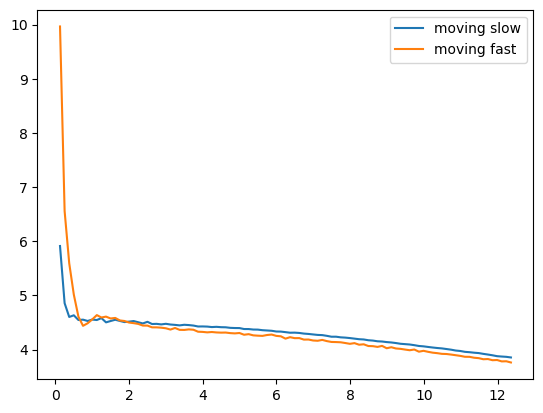

In [20]:
a_spec = list()
b_spec = list()

trial_task1 = list()
trial_task2 = list()

N = 8200
dt = 1/1024
t = np.arange(0, N*dt, dt) # 時間軸
freq = np.fft.fftfreq(N,d=dt) # 周波数軸
for i in range(90):
    for j in range(64):
        F1 = np.fft.fft(sta_data[i][j])
        F2 = np .fft.fft(com_data[i][j])
        # 振幅スペクトルを計算
        amplitude1 = np.abs(F1)
        amplitude2 = np.abs(F2)
        F_amplitude1 = amplitude1 / N * 2
        F_amplitude1[0] = F_amplitude1[0] / 2
        F_amplitude2 = amplitude2 / N * 2
        F_amplitude2[0] = F_amplitude2[0] / 2
        a_spec.append(F_amplitude1)
        b_spec.append(F_amplitude2)
    alp = sum(a_spec)
    bta = sum(b_spec)
    trial_task1.append(alp)
    trial_task2.append(bta)
trial_task1_all = sum(trial_task1)/(64*90)
trial_task2_all = sum(trial_task2)/(64*90)
print(np.shape(a_spec))
plt.plot(freq[1:100],trial_task1_all[1:100],label= 'moving slow')
plt.plot(freq[1:100],trial_task2_all[1:100],label= 'moving fast')
plt.legend()
plt.show()


